# ML2025 Homework 6 - Fine-tuning leads to Forgetting

This notebook is for ML2025 Homework 6, focusing on the problem of fine-tuning leading to forgetting. The goal is to fine-tune a model using the GSM8K dataset while observing the effects on previously learned knowledge about safeness.

## Check GPU

In [1]:
!nvidia-smi

Thu May  8 22:56:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Download Dataset & Install Packages

In [2]:
!wget https://www.csie.ntu.edu.tw/~b10902031/gsm8k_train.jsonl # original dataset for fine-tuning
!wget https://www.csie.ntu.edu.tw/~b10902031/gsm8k_train_self-instruct.jsonl # part of fine-tuning dataset refined by llama-3.2-1b-instruct
!wget https://www.csie.ntu.edu.tw/~b10902031/gsm8k_test_public.jsonl # gsm8k public test dataset
!wget https://www.csie.ntu.edu.tw/~b10902031/gsm8k_test_private.jsonl # gsm8k private test dataset
!wget https://www.csie.ntu.edu.tw/~b10902031/ailuminate_test.csv # ailuminate test dataset (public + private)

--2025-05-08 22:56:02--  https://www.csie.ntu.edu.tw/~b10902031/gsm8k_train.jsonl
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4166206 (4.0M)
Saving to: ‘gsm8k_train.jsonl’

gsm8k_train.jsonl   100%[===================>]   3.97M  2.11MB/s    in 1.9s    

2025-05-08 22:56:05 (2.11 MB/s) - ‘gsm8k_train.jsonl’ saved [4166206/4166206]

--2025-05-08 22:56:05--  https://www.csie.ntu.edu.tw/~b10902031/gsm8k_train_self-instruct.jsonl
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4912246 (4.7M)
Saving to: ‘gsm8k_train_self-instruct.jsonl’

gsm8k_train_self-in 100%[===================>]   4.68M  3.08MB/s    in 1.5s    

2025-05-08 22:56:07 (3.08 MB/s) - ‘gsm8k_train_

In [3]:
!pip install -U datasets trl bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstal

## Huggingface Login

In [4]:
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login

hf_token = UserSecretsClient().get_secret("HF_TOKEN")
login(token=hf_token)
# !huggingface-cli login --token hf_token # TODO: Add your huggingface token

## Import Packages

In [5]:
from transformers import (
    AutoModelForCausalLM, # imports the model for causal language modeling
    AutoTokenizer, # imports the tokenizer for the model
    BitsAndBytesConfig, # imports the configuration for using bitsandbytes
    pipeline # imports the pipeline for text generation
)
from peft import (
    LoraConfig, # imports the configuration for LoRA
    get_peft_model, # imports the function to get the PEFT model
    PeftModel # imports the PEFT model
)
import os
import json
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # Sets the CUDA device to use
device = torch.device('cuda:0') # Creates a CUDA device object
from datasets import Dataset # Imports the Dataset class from the datasets library
from trl import SFTConfig, SFTTrainer # Imports the SFTConfig and SFTTrainer classes from the trl library
import random
random.seed(1126) # Sets the random seed for reproducibility
from tqdm import tqdm # Imports the tqdm library for progress bars
import csv
from transformers.utils import logging
logging.set_verbosity_info()

2025-05-08 22:58:00.253926: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746745080.459073      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746745080.516073      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## LLM Fine-tuning

### Load Model & Tokenizer

In [6]:
sft_model_name = 'meta-llama/Llama-3.2-1B-Instruct' # Specifies the name of the pre-trained model to use
sft_bnb_config = BitsAndBytesConfig( # Configuration for using bitsandbytes
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
sft_model = AutoModelForCausalLM.from_pretrained( # Loads the pre-trained model
    pretrained_model_name_or_path=sft_model_name,
    quantization_config=sft_bnb_config,
    low_cpu_mem_usage=True,
)
sft_tokenizer = AutoTokenizer.from_pretrained( # Loads the tokenizer for the model
    pretrained_model_name_or_path=sft_model_name,
)
sft_tokenizer.add_special_tokens({'pad_token': '[PAD]'}) # Adds a special token for padding
peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    # TODO: Adds dropout
    bias='none',
    task_type='CAUSAL_LM',
    target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj']
)
peft_model = get_peft_model(sft_model, peft_config)

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16"

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/model.safetensors
Instantiating LlamaForCausalLM model under default dtype torch.float16.
Generate config GenerationConfig {
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ]
}

All model checkpoint weights were used when initializing LlamaForCausalLM.

All the weights of LlamaForCausalLM were initialized from the model checkpoint at meta-llama/Llama-3.2-1B-Instruct.
If your task is similar to the task the model of the checkpoint was trained on, you can already use LlamaForCausalLM for predictions without further training.


generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 128000,
  "do_sample": true,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "temperature": 0.6,
  "top_p": 0.9
}



tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/tokenizer.json
loading file tokenizer.model from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/tokenizer_config.json
loading file chat_template.jinja from cache at None
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Dataset Formatting Functions

In [7]:
def load_jsonlines(file_name: str):
    f = open(file_name, 'r')
    return [json.loads(line) for line in f]

def nshot_chats(nshot_data: list, question: str, answer: any, mode: str, examples: list) -> dict: # Function to create n-shot chats
    if mode not in ['train', 'test']:
        raise AssertionError('Undefined Mode!!!')

    chats = []
    # TODO: Use fixed few-shot examples
    for qna in examples: # Samples n examples from the n-shot data
        chats.append(
            {
                'role': 'user',
                'content': f'Q: {qna["question"]}' # Creates a user message with the question
            }
        )
        chats.append(
            {
                'role': 'assistant',
                'content': f'A: {qna["answer"]}' # Creates an assistant message with the answer
            }
        )

    chats.append(
        {
            'role': 'user',
            'content': f'Q: {question} Let\'s think step by step. At the end, you MUST write the answer as an integer after \'####\'.' # Creates a user message with the question and instructions
        }
    )
    if mode == 'train':
        chats.append(
            {
                'role': 'assistant',
                'content': f'A: {answer}' # Creates an assistant message with the answer
            }
        )

    return chats # Returns the list of chats

### Format GSM8K Data for Fine-tuning

In [8]:
sorted_gsm8k = load_jsonlines('gsm8k_train_self-instruct.jsonl')

def gsm8k_len(qna):
    single_ex = []
    single_ex.append(
        {
            'role': 'user',
            'content': f'Q: {qna["question"]}' # Creates a user message with the question
        }
    )
    single_ex.append(
        {
            'role': 'assistant',
            'content': f'A: {qna["answer"]}' # Creates an assistant message with the answer
        }
    )
    train_sample = sft_tokenizer.apply_chat_template(single_ex, tokenize=False)
    return len(sft_tokenizer(train_sample)['input_ids'])

sorted_gsm8k.sort(key=lambda item: gsm8k_len(item))

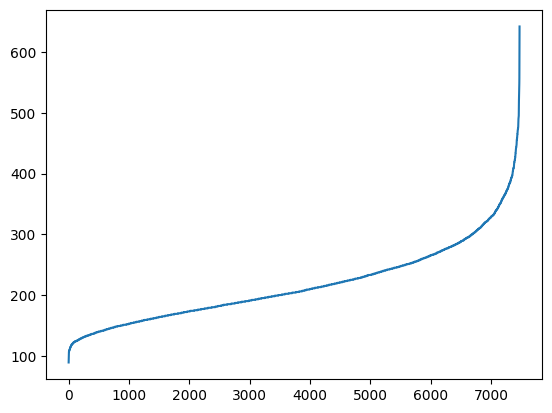

In [9]:
import matplotlib.pyplot as plt
import numpy as np
sorted_len = np.zeros(len(sorted_gsm8k))
for i in range(len(sorted_gsm8k)):
    sorted_len[i] = gsm8k_len(sorted_gsm8k[i])

plt.plot(sorted_len)
plt.show()

In [10]:
examples = [sorted_gsm8k[0], sorted_gsm8k[10], sorted_gsm8k[20], sorted_gsm8k[30], sorted_gsm8k[40]]
print(f"examples: {examples}")

examples: [{'question': 'What is fifteen more than a quarter of 48?', 'answer': 'First, find a quarter of 48: 48/4 = 12\nThen, add 15 to that: 12 + 15 = 27\n#### 27'}, {'question': 'Megan pays $16 for a shirt that costs $22 before sales. What is the amount of the discount?', 'answer': 'The discount is the difference between the original price and the price Megan paid. \nThe original price is $22.\nThe price Megan paid is $16.\nThe discount is $22 - $16 = $6.\n#### 6'}, {'question': 'While passing by a store, Miley noticed that a bag that cost $150 last week is now on sale for $135. What percent is the discount?', 'answer': 'The discount is $150 - $135 = $15.\nThe discount as a percentage of the original price is ($15 / $150) * 100 = 10%.\n#### 10'}, {'question': 'Marcel bought a pen for $4, and a briefcase for five times the price. How much did Marcel pay for both items?', 'answer': 'First, find the price of the briefcase: 5 * $4 = $20.\nThen add the price of the pen to the price of th

In [11]:
gsm8k_train = load_jsonlines('gsm8k_train_self-instruct.jsonl') # You can use refined gsm8k_train_self-instruct.jsonl for fine-tuning
# gsm8k_train = load_jsonlines('gsm8k_train.jsonl')

formatted_gsm8k = []
TRAIN_N_SHOT = 5 # TODO: Give model more examples: 5~8
max_token_len = 0 # Record token length of dataset and prevent data from truncation

for qna in gsm8k_train: # Iterates over the GSM8K training data
    chats = nshot_chats(nshot_data=gsm8k_train, question=qna['question'], answer=qna['answer'], mode='train', examples = examples) # Creates n-shot chats for the current example
    train_sample = sft_tokenizer.apply_chat_template(chats, tokenize=False) # Applies the chat template to the chats
    train_sample = train_sample[train_sample.index("<|eot_id|>") + len("<|eot_id|>"):] # Remove Cutting Knowledge Date in prompt template
    formatted_gsm8k.append( # Appends the formatted example to the list
        {
            'text': train_sample # Adds the text of the example
        }
    )
    max_token_len = max(max_token_len, len(sft_tokenizer(train_sample)['input_ids'])) # Updates the maximum token length

formatted_gsm8k = Dataset.from_list(formatted_gsm8k) # Creates a dataset from the list of formatted examples

### Fine-tuning

In [12]:
# trainer
# Add a learning rate scheduler with warm-up
from transformers import get_scheduler

training_arguments = SFTConfig( # Configuration for the SFT trainer
    seed=1126,
    data_seed=1126,
    output_dir=f"sft",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    num_train_epochs=2, # TODO: If you use fixed few-shot examples, increase epoch
    logging_strategy="steps",
    logging_steps=0.1/2,
    save_strategy="steps",
    save_steps=0.1/2,
    lr_scheduler_type='linear',
    learning_rate=1e-4, # TODO: Decrease learning rate: 1e-4~1e-5
    warmup_ratio=0.1,
    # TODO: Add weight decay
    bf16=True,
    group_by_length=True,
    max_seq_length=max_token_len,
    dataset_text_field='text',
    report_to='none',
)
trainer = SFTTrainer( # Creates the SFT trainer
    model=peft_model,
    train_dataset=formatted_gsm8k,
    peft_config=peft_config,
    processing_class=sft_tokenizer,
    args=training_arguments,
)
trainer.train() # Starts the training process

PyTorch: setting up devices


Converting train dataset to ChatML:   0%|          | 0/7472 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/7472 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/7472 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/7472 [00:00<?, ? examples/s]

Using auto half precision backend
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 7,472
  Num Epochs = 2
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 3,736
  Number of trainable parameters = 5,636,096


Step,Training Loss
187,0.719200
374,0.270800
561,0.238900
748,0.233600
935,0.236500
1122,0.232400
1309,0.230500
1496,0.229200
1683,0.231200
1870,0.225400


Saving model checkpoint to sft/checkpoint-187
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-3.2-1B-Instruct/snapshots/9213176726f574b556790deb65791e0c5aa438b6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_

TrainOutput(global_step=3736, training_loss=0.25081438987617577, metrics={'train_runtime': 15088.116, 'train_samples_per_second': 0.99, 'train_steps_per_second': 0.248, 'total_flos': 5.425380774147686e+16, 'train_loss': 0.25081438987617577})